# NHL Modeling + ROI Backtest (rebuild)
This notebook rebuilds the modeling + ROI pipeline with **robust alignment** between:
- the test-set predictions (`p_home`)
- the backtest frame (`df_bt`)
- the odds CSV

Key fix: after merging odds, we **map probabilities by `gamePk`** (not by row position), preventing length-mismatch and silent misalignment.


In [18]:

import os, re, sqlite3, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Load data
Preferred: union from SQLite `games_table_*` (excluding `games_table_20202021`).
Fallback: load a CSV you already exported.


In [19]:

DB_PATH = "nhl_scrape.sqlite"            # adjust if needed
CSV_FALLBACK = "test.csv"               # adjust if needed
ODDS_CSV = "nhl_odds_2023_2024_closing.csv"  # your odds file (opening/closing)

OMIT_TABLES = {"games_table_20202021"}  # COVID season excluded
TABLE_PREFIX = "games_table_"

def load_union_from_sqlite(db_path=DB_PATH):
    if not os.path.exists(db_path):
        return None

    conn = sqlite3.connect(db_path)
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)["name"].tolist()
    keep = [t for t in tables if t.startswith(TABLE_PREFIX) and t not in OMIT_TABLES]
    if not keep:
        conn.close()
        return None

    dfs = []
    for t in sorted(keep):
        df_t = pd.read_sql(f"SELECT * FROM {t};", conn)
        df_t["season_table"] = t
        dfs.append(df_t)
    conn.close()
    df = pd.concat(dfs, ignore_index=True)
    return df

df = load_union_from_sqlite(DB_PATH)
if df is None:
    print(f"[load] SQLite not found or no tables; using CSV fallback: {CSV_FALLBACK}")
    df = pd.read_csv(CSV_FALLBACK)

print("[load] df shape:", df.shape)
df.head(3)


[load] df shape: (10304, 191)


,gamePk,season,gameDate,homeTeamAbbrev_x,awayTeamAbbrev_x,homeTeamName,awayTeamName,homeWin,homeTeamAbbrev_y,home_season_GF_mean,...,away_season_FO_PCT_rank,away_season_HITS_rank,away_season_BLKS_rank,away_season_PIM_rank,away_season_GIVE_rank,away_season_TAKE_rank,away_season_SHPCT_rank,away_season_SVPCT_rank,away_season_PDO_rank,season_table
0,2015020164,20152016,2015-11-01 00:00:00,COL,SJS,"{""default"":""Avalanche""}","{""default"":""Sharks""}",0.0,COL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016
1,2015020165,20152016,2015-11-01 00:00:00,CAR,TBL,"{""default"":""Hurricanes""}","{""default"":""Lightning""}",0.0,CAR,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016
2,2015020166,20152016,2015-11-01 00:00:00,MTL,WPG,"{""default"":""Canadiens""}","{""default"":""Jets""}",1.0,MTL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016


## 2) Clean columns + define target, clean features
We keep `gamePk`, `gameDate`, `season`, `homeWin` and build `X` from numeric feature columns.

Important: your union sometimes contains duplicate abbrev columns (e.g., `homeTeamAbbrev_x`/`_y`). We standardize to a single `homeTeamAbbrev` / `awayTeamAbbrev` when present.


In [20]:
DB_PATH = "nhl_scrape.sqlite"

# Explicitly list seasons to include
TABLES = [
    "games_table_20152016",
    "games_table_20162017",
    "games_table_20172018",
    "games_table_20182019",
    "games_table_20192020",
    # "games_table_20202021",  # ❌ OMIT (COVID)
    "games_table_20212022",
    "games_table_20222023",
    "games_table_20232024",
    "games_table_20242025",
]

conn = sqlite3.connect(DB_PATH)

dfs = []
for t in TABLES:
    print(f"Loading {t}")
    df_t = pd.read_sql(f"SELECT * FROM {t}", conn)
    df_t["season_table"] = t  # optional but useful for debugging
    dfs.append(df_t)

conn.close()

df = pd.concat(dfs, axis=0, ignore_index=True)

df.to_csv('test.csv')

# final sort (critical)
df = df.sort_values(["gameDate", "gamePk"]).reset_index(drop=True)

print(df.shape)
df.head()


Loading games_table_20152016
Loading games_table_20162017
Loading games_table_20172018
Loading games_table_20182019
Loading games_table_20192020
Loading games_table_20212022
Loading games_table_20222023
Loading games_table_20232024
Loading games_table_20242025
(9853, 191)


,gamePk,season,gameDate,homeTeamAbbrev_x,awayTeamAbbrev_x,homeTeamName,awayTeamName,homeWin,homeTeamAbbrev_y,home_season_GF_mean,...,away_season_FO_PCT_rank,away_season_HITS_rank,away_season_BLKS_rank,away_season_PIM_rank,away_season_GIVE_rank,away_season_TAKE_rank,away_season_SHPCT_rank,away_season_SVPCT_rank,away_season_PDO_rank,season_table
0,2015020164,20152016,2015-11-01 00:00:00,COL,SJS,"{""default"":""Avalanche""}","{""default"":""Sharks""}",0.0,COL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016
1,2015020165,20152016,2015-11-01 00:00:00,CAR,TBL,"{""default"":""Hurricanes""}","{""default"":""Lightning""}",0.0,CAR,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016
2,2015020166,20152016,2015-11-01 00:00:00,MTL,WPG,"{""default"":""Canadiens""}","{""default"":""Jets""}",1.0,MTL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016
3,2015020167,20152016,2015-11-01 00:00:00,NYI,BUF,"{""default"":""Islanders""}","{""default"":""Sabres""}",0.0,NYI,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016
4,2015020168,20152016,2015-11-01 00:00:00,ANA,NSH,"{""default"":""Ducks""}","{""default"":""Predators""}",1.0,ANA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,games_table_20152016


In [21]:
TARGET = "homeWin"

# drop rows with missing target
df = df.dropna(subset=[TARGET]).copy()

# sort chronologically (critical)
df = df.sort_values(["gameDate", "gamePk"]).reset_index(drop=True)

print(df[TARGET].mean())

def make_diff_features(df):
    diff_cols = []
    for c in df.columns:
        if c.startswith("home_") and c.replace("home_", "away_") in df.columns:
            diff_name = c.replace("home_", "diff_")
            df[diff_name] = df[c] - df[c.replace("home_", "away_")]
            diff_cols.append(diff_name)
    return df, diff_cols

df, DIFF_COLS = make_diff_features(df)
len(DIFF_COLS)

0.5417639297675835


90

In [22]:
DROP_COLS = [
    TARGET,
    "gamePk",
    "gameDate",
]

X = df[DIFF_COLS].replace([np.inf, -np.inf], np.nan)
y = df[TARGET].astype(int)

# drop columns that are mostly missing
valid_cols = X.columns[X.isna().mean() < 0.30]
X = X[valid_cols]


print(X.shape)

(9853, 90)


In [23]:
def drop_high_corr(X, thresh=0.95):
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop = [c for c in upper.columns if any(upper[c] > thresh)]
    return X.drop(columns=drop), drop

X_corr, dropped_corr = drop_high_corr(X, thresh=0.95)
print(f"Dropped {len(dropped_corr)} correlated features")

Dropped 0 correlated features


## 4) Chronological split
We split chronologically: last **two seasons worth of games** as test.
If your `season` is an 8-digit like `20232024`, we take the max 2 season codes as test.


In [24]:

if "season" not in df.columns:
    raise ValueError("df must include a 'season' column for chronological split.")

season_vals = sorted(df["season"].dropna().unique().tolist())
if len(season_vals) < 3:
    raise ValueError(f"Not enough seasons in data to do a 2-season holdout. Seasons found: {season_vals}")

test_seasons = season_vals[-2:]
train_mask = ~df["season"].isin(test_seasons)
test_mask  = df["season"].isin(test_seasons)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

# cols = X_train.columns.tolist()

# drop_patterns = [
#     "_std",                # drop all stds
# ]

# def should_drop(c):
#     return any(p in c for p in drop_patterns)

# keep_cols = [c for c in cols if not should_drop(c)]

# X_train = X_train[keep_cols]
# X_test = X_test[keep_cols]

df_train = df.loc[train_mask, ["gamePk","gameDate","season","homeWin"]].copy()
df_test  = df.loc[test_mask,  ["gamePk","gameDate","season","homeWin"]].copy()

print("[split] train seasons:", season_vals[0], "…", season_vals[-3])
print("[split] test seasons :", test_seasons)
print("[split] X_train:", X_train.shape, "X_test:", X_test.shape)


[split] train seasons: 20152016 … 20222023
[split] test seasons : [20232024, 20242025]
[split] X_train: (7555, 90) X_test: (2298, 90)


## 5) Models
- Logit (scaled)
- RandomForest (no scaling)

(You can re-add XGBoost/LightGBM/ANN later; the backtest alignment fix is model-agnostic.)


In [25]:

logit = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=None))
])

rf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        n_estimators=600,
        min_samples_leaf=10,
        max_features="sqrt",
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

def evaluate(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    p_tr = model.predict_proba(X_tr)[:,1]
    p_te = model.predict_proba(X_te)[:,1]
    return {
        "train_logloss": log_loss(y_tr, p_tr),
        "test_logloss": log_loss(y_te, p_te),
        "train_auc": roc_auc_score(y_tr, p_tr),
        "test_auc": roc_auc_score(y_te, p_te),
        "test_brier": brier_score_loss(y_te, p_te),
        "test_acc": accuracy_score(y_te, (p_te>=0.5).astype(int))
    }, p_te

results = []
preds = {}

for name, model in [("Logit", logit), ("RandomForest", rf)]:
    res, p = evaluate(model, X_train, y_train, X_test, y_test)
    res["model"] = name
    results.append(res)
    preds[name] = pd.Series(p, index=X_test.index, name="p_home")  # keep index!

pd.DataFrame(results).sort_values("test_logloss")


,train_logloss,test_logloss,train_auc,test_auc,test_brier,test_acc,model
1,0.464956,0.668892,0.993088,0.608826,0.238216,0.588773,RandomForest
0,0.667794,0.670470,0.621929,0.610086,0.238989,0.581375,Logit


## 6) Load odds + build backtest frame (alignment-safe)
Critical: we merge odds on `gamePk`, then map `p_home` using `gamePk`->probability mapping.
This prevents the exact error you hit: `Length of values ... does not match length of index` and also prevents silent misalignment when an `inner` merge drops games.


In [26]:

ODDS_BOOK_COLS = ["gamePk","home_odds","away_odds","book","which_line","date"]

odds = pd.read_csv(ODDS_CSV)
odds["gamePk"] = odds["game_id"].astype(str)
# If odds file uses 'date' as YYYY-MM-DD, keep it; otherwise derive from gameDate later.
odds_small = odds[[c for c in ODDS_BOOK_COLS if c in odds.columns]].drop_duplicates("gamePk", keep="last")

print("[odds] rows:", len(odds_small), "cols:", odds_small.columns.tolist())
odds_small.head(3)


[odds] rows: 2214 cols: ['gamePk', 'home_odds', 'away_odds', 'book', 'which_line', 'date']


,gamePk,home_odds,away_odds,book,which_line,date
0,2023020141,-110.0,-110.0,fanduel,currentLine,2023-11-01
1,2023020142,118.0,-142.0,fanduel,currentLine,2023-11-01
2,2023020143,-240.0,195.0,fanduel,currentLine,2023-11-01


In [27]:

def american_to_decimal(a):
    a = float(a)
    if a > 0:
        return 1.0 + (a / 100.0)
    else:
        return 1.0 + (100.0 / abs(a))

def implied_prob_from_american(a):
    a = float(a)
    if a > 0:
        return 100.0 / (a + 100.0)
    else:
        return abs(a) / (abs(a) + 100.0)

def kelly_fraction(p, dec_odds):
    # p = win prob, dec_odds = decimal odds (includes stake)
    # Kelly for binary bet: f* = (bp - q)/b where b = dec-1, q=1-p
    b = float(dec_odds) - 1.0
    if b <= 0:
        return 0.0
    q = 1.0 - float(p)
    f = (b*float(p) - q) / b
    return max(0.0, f)

def summarize_backtest(df_bets, equity, start_bankroll):
    eq = np.array(equity, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = (eq - peak) / peak
    profit = df_bets["pnl"].sum() if len(df_bets) else 0.0
    stake = df_bets["stake"].sum() if len(df_bets) else 0.0
    roi = profit / stake if stake > 0 else 0.0
    hit_rate = (df_bets["pnl"] > 0).mean() if len(df_bets) else 0.0
    return {
        "n_bets": int(len(df_bets)),
        "roi": float(roi),
        "profit": float(profit),
        "ending_bankroll": float(eq[-1]),
        "max_drawdown": float(dd.min()) if len(eq) else 0.0,
        "hit_rate": float(hit_rate),
        "avg_edge": float(df_bets["edge"].mean()) if len(df_bets) else 0.0,
        "avg_stake": float(df_bets["stake"].mean()) if len(df_bets) else 0.0,
    }


In [28]:

# Pick model
MODEL_NAME = "Logit"   # change to "RandomForest" if desired

# Build df_bt from df_test and align-safe p_home mapping
df_bt = df_test[["gamePk","gameDate","homeWin"]].copy()
df_bt["gamePk"] = df_bt["gamePk"].astype(str)

# Create mapping: row-index -> probability, then attach to gamePk
p_home_series = preds[MODEL_NAME]
df_bt["p_home"] = p_home_series.loc[df_test.index].values  # same length as df_test
df_bt["p_away"] = 1.0 - df_bt["p_home"]

# Merge odds (inner merge will drop games without odds)
df_bt = df_bt.merge(odds_small, on="gamePk", how="inner")
print("[bt] games after odds merge:", len(df_bt))

# Convert odds -> decimal + implied
df_bt["home_dec"] = df_bt["home_odds"].map(american_to_decimal)
df_bt["away_dec"] = df_bt["away_odds"].map(american_to_decimal)
df_bt["home_imp"] = df_bt["home_odds"].map(implied_prob_from_american)
df_bt["away_imp"] = df_bt["away_odds"].map(implied_prob_from_american)

df_bt.head(3)


[bt] games after odds merge: 2214


,gamePk,gameDate,homeWin,p_home,p_away,home_odds,away_odds,book,which_line,date,home_dec,away_dec,home_imp,away_imp
0,2023020141,2023-11-01 00:00:00,0.0,0.538951,0.461049,-110.0,-110.0,fanduel,currentLine,2023-11-01,1.909091,1.909091,0.523810,0.523810
1,2023020142,2023-11-01 00:00:00,0.0,0.538951,0.461049,118.0,-142.0,fanduel,currentLine,2023-11-01,2.180000,1.704225,0.458716,0.586777
2,2023020143,2023-11-01 00:00:00,1.0,0.538951,0.461049,-240.0,195.0,fanduel,currentLine,2023-11-01,1.416667,2.950000,0.705882,0.338983


## 7) Backtest cell (with max-edge + optional edge-bin exclusions)
This is the cell you keep tweaking. It enforces:
- `edge` in `[MIN_EDGE, MAX_EDGE]`
- stake sizing via Kelly fraction * `KELLY_SCALE`, capped at `MAX_STAKE_FRAC`
- optional exclusion of an edge bucket interval (e.g., exclude 3%-5%).


In [29]:

START_BANKROLL = 3000.0
KELLY_SCALE = 0.10
MAX_STAKE_FRAC = 0.02

MIN_EDGE = 0.01
MAX_EDGE = 0.25

# Optional: exclude a bad edge bucket, e.g. (0.03, 0.05)
# EXCLUDE_EDGE_BAND = (0.03, 0.05)  # set to None to disable
EXCLUDE_EDGE_BAND = None

# Expected value per $1 stake
df_bt["ev_home"] = df_bt["p_home"] * df_bt["home_dec"] - 1.0
df_bt["ev_away"] = df_bt["p_away"] * df_bt["away_dec"] - 1.0

# Pick side
df_bt["side"] = np.where(df_bt["ev_home"] >= df_bt["ev_away"], "home", "away")
df_bt["ev"]   = np.where(df_bt["side"] == "home", df_bt["ev_home"], df_bt["ev_away"])

# Edge vs implied
df_bt["edge_home"] = df_bt["p_home"] - df_bt["home_imp"]
df_bt["edge_away"] = df_bt["p_away"] - df_bt["away_imp"]
df_bt["edge"]      = np.where(df_bt["side"] == "home", df_bt["edge_home"], df_bt["edge_away"])

# Enforce hard max edge by filtering (not capping the column)
df_bt["bet"] = (
    np.isfinite(df_bt["ev"]) &
    (df_bt["edge"] >= MIN_EDGE) &
    (df_bt["edge"] <= MAX_EDGE)
)

if EXCLUDE_EDGE_BAND is not None:
    lo, hi = EXCLUDE_EDGE_BAND
    df_bt["bet"] = df_bt["bet"] & ~((df_bt["edge"] > lo) & (df_bt["edge"] <= hi))

# Optional odds-band filter (home-decimal)
df_bt = df_bt[(df_bt["home_dec"] >= 1.6) & (df_bt["home_dec"] <= 2.3)].copy()

# Log-odds gap filter (on home line)
logit_market = np.log(df_bt["home_imp"] / (1 - df_bt["home_imp"]))
logit_model  = np.log(df_bt["p_home"]   / (1 - df_bt["p_home"]))
df_bt["logodds_gap"] = logit_model - logit_market
df_bt = df_bt[df_bt["logodds_gap"].abs() > 0.15].copy()

# Kelly sizing
df_bt["p"]   = np.where(df_bt["side"] == "home", df_bt["p_home"], df_bt["p_away"])
df_bt["dec"] = np.where(df_bt["side"] == "home", df_bt["home_dec"], df_bt["away_dec"])
df_bt["kelly_f"] = df_bt.apply(lambda r: kelly_fraction(r["p"], r["dec"]), axis=1)
df_bt["stake_frac"] = np.minimum(MAX_STAKE_FRAC, KELLY_SCALE * df_bt["kelly_f"])
df_bt.loc[~df_bt["bet"], "stake_frac"] = 0.0

# Simulate chronologically
df_bt = df_bt.sort_values("gameDate").reset_index(drop=True)

bankroll = START_BANKROLL
equity = [bankroll]
bet_rows = []

for r in df_bt.itertuples(index=False):
    stake = bankroll * float(r.stake_frac)
    if stake <= 0:
        equity.append(bankroll)
        continue

    home_won = int(r.homeWin) == 1
    win = home_won if r.side == "home" else (not home_won)
    pnl = stake * (float(r.dec) - 1.0) if win else -stake

    bankroll += pnl
    equity.append(bankroll)

    bet_rows.append({
        "gamePk": r.gamePk,
        "gameDate": r.gameDate,
        "side": r.side,
        "p": float(r.p),
        "dec": float(r.dec),
        "edge": float(r.edge),
        "stake": float(stake),
        "pnl": float(pnl),
        "bankroll": float(bankroll),
    })

df_bets = pd.DataFrame(bet_rows)
summary = summarize_backtest(df_bets, equity, START_BANKROLL)

summary


{'n_bets': 590,
 'roi': -0.049347239053158326,
 'profit': -863.7879937224635,
 'ending_bankroll': 2136.2120062775366,
 'max_drawdown': -0.45412447267426764,
 'hit_rate': 0.4864406779661017,
 'avg_edge': 0.07453376543187128,
 'avg_stake': 29.668274762243747}

In [30]:

# Diagnostics: edge bins
bins = [-0.001, 0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 1.0]
labels = pd.IntervalIndex.from_breaks(bins)
if len(df_bets):
    df_bets["edge_bin"] = pd.cut(df_bets["edge"], bins=bins)
    edge_tbl = df_bets.groupby("edge_bin").agg(
        n=("edge","size"),
        profit=("pnl","sum"),
        stake=("stake","sum"),
    )
    edge_tbl["roi"] = edge_tbl["profit"]/edge_tbl["stake"]
    edge_tbl
else:
    print("No bets placed under current filters.")


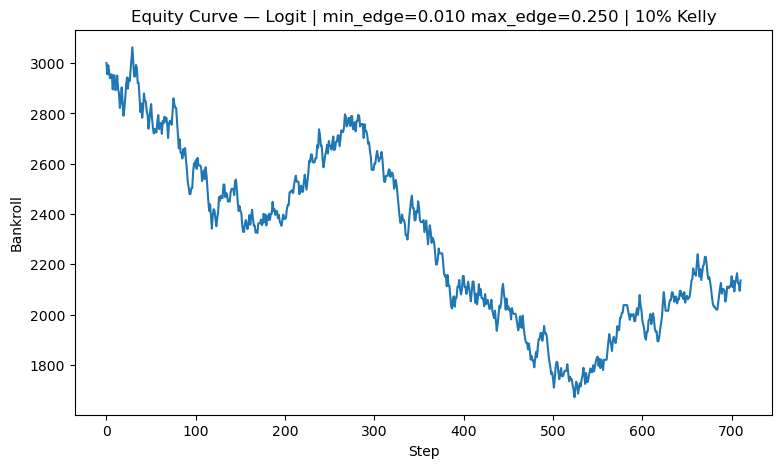

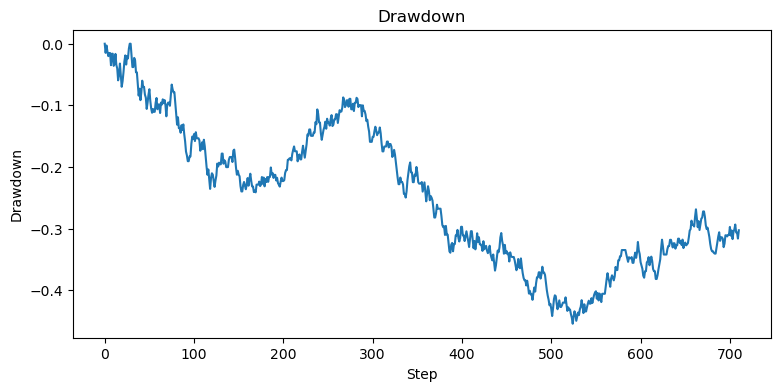

Summary: {'n_bets': 590, 'roi': -0.049347239053158326, 'profit': -863.7879937224635, 'ending_bankroll': 2136.2120062775366, 'max_drawdown': -0.45412447267426764, 'hit_rate': 0.4864406779661017, 'avg_edge': 0.07453376543187128, 'avg_stake': 29.668274762243747}
Bets placed: 590


,gamePk,gameDate,side,p,dec,edge,stake,pnl,bankroll,edge_bin
0,2023020142,2023-11-01 00:00:00,home,0.538951,2.180000,0.080236,44.469527,-44.469527,2955.530473,"(0.08, 0.12]"
1,2023020144,2023-11-01 00:00:00,home,0.538951,2.080000,0.058182,33.117912,35.767345,2991.297818,"(0.05, 0.08]"
2,2023020147,2023-11-02 00:00:00,home,0.538951,2.040000,0.048755,28.607252,-28.607252,2962.690566,"(0.03, 0.05]"
3,2023020150,2023-11-02 00:00:00,home,0.538951,2.000000,0.038951,23.080032,-23.080032,2939.610534,"(0.03, 0.05]"
4,2023020152,2023-11-02 00:00:00,away,0.461049,2.280000,0.022452,11.756470,15.048281,2954.658815,"(0.02, 0.03]"
5,2023020158,2023-11-03 00:00:00,away,0.711645,1.666667,0.111645,59.093176,-59.093176,2895.565639,"(0.08, 0.12]"
6,2023020173,2023-11-04 00:00:00,home,0.622547,1.961538,0.112743,57.911313,55.683955,2951.249593,"(0.08, 0.12]"
7,2023020170,2023-11-04 00:00:00,home,0.728491,1.869565,0.193607,59.024992,-59.024992,2892.224601,"(0.12, 1.0]"
8,2023020167,2023-11-04 00:00:00,away,0.596082,1.729927,0.018023,12.354041,9.017548,2901.242150,"(0.01, 0.02]"
9,2023020164,2023-11-04 00:00:00,home,0.677780,1.847458,0.136496,58.024843,49.173596,2950.415745,"(0.12, 1.0]"


In [31]:

# Plot equity + drawdown
import matplotlib.pyplot as plt

eq = np.array(equity, dtype=float)
peak = np.maximum.accumulate(eq)
dd = (eq - peak) / peak

plt.figure(figsize=(9,5))
plt.plot(eq)
plt.title(f"Equity Curve — {MODEL_NAME} | min_edge={MIN_EDGE:.3f} max_edge={MAX_EDGE:.3f} | {int(KELLY_SCALE*100)}% Kelly")
plt.xlabel("Step")
plt.ylabel("Bankroll")
plt.show()

plt.figure(figsize=(9,4))
plt.plot(dd)
plt.title("Drawdown")
plt.xlabel("Step")
plt.ylabel("Drawdown")
plt.show()

print("Summary:", summary)
print("Bets placed:", len(df_bets))
df_bets.head(10)


In [32]:
bets = df_bets.copy()
bets["edge_bin"] = pd.cut(bets["edge"], bins=[0, .01, .02, .03, .05, .08, .12, 1.0], include_lowest=True)

roi_by = bets.groupby("edge_bin").agg(
    n=("pnl","size"),
    profit=("pnl","sum"),
    stake=("stake","sum"),
).reset_index()

roi_by["roi"] = roi_by["profit"] / roi_by["stake"]
roi_by


,edge_bin,n,profit,stake,roi
0,"(-0.001, 0.01]",0,0.000000,0.000000,NaN
1,"(0.01, 0.02]",57,-17.474511,419.703916,-0.041635
2,"(0.02, 0.03]",30,-2.859308,356.127515,-0.008029
3,"(0.03, 0.05]",118,-61.407142,2285.094157,-0.026873
4,"(0.05, 0.08]",174,99.603523,5177.162111,0.019239
5,"(0.08, 0.12]",127,161.931268,5395.421831,0.030013
6,"(0.12, 1.0]",84,-1043.581824,3870.772581,-0.269606


,segment,edge_bin,n,profit,stake,roi
0,Home Favorite,3–5%,19,-0.355197,426.535742,-0.000833
1,Home Favorite,5–8%,57,-207.259079,1911.824954,-0.108409
2,Home Underdog,3–5%,30,-6.763394,599.348108,-0.011285
3,Home Underdog,5–8%,49,77.484180,1296.292488,0.059774
4,Road Favorite,<0–2%,28,-9.708695,228.416492,-0.042504
5,Road Favorite,2–3%,11,-19.469635,157.054739,-0.123967
6,Road Favorite,3–5%,24,-38.875777,510.234042,-0.076192
7,Road Favorite,5–8%,23,217.565487,698.285435,0.311571
8,Road Underdog,<0–2%,29,-7.765816,191.287425,-0.040598
9,Road Underdog,2–3%,19,16.610327,199.072776,0.083438


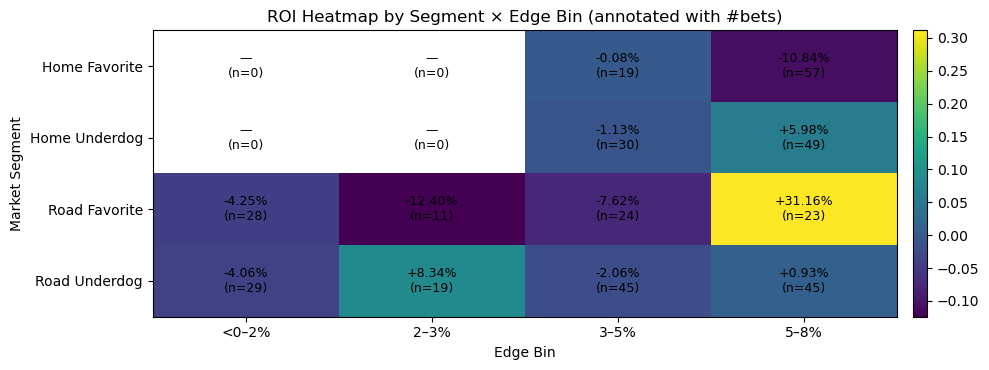

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_viz = df_bets.copy()

# --- numeric safety ---
df_viz["edge"]  = pd.to_numeric(df_viz["edge"], errors="coerce")
df_viz["pnl"]   = pd.to_numeric(df_viz["pnl"], errors="coerce")
df_viz["stake"] = pd.to_numeric(df_viz["stake"], errors="coerce")
df_viz["dec"]   = pd.to_numeric(df_viz["dec"], errors="coerce")

# --- context ---
df_viz["is_home"] = df_viz["side"].eq("home")
df_viz["is_away"] = ~df_viz["is_home"]
df_viz["is_favorite"] = df_viz["dec"] < 2.0
df_viz["is_underdog"] = ~df_viz["is_favorite"]

df_viz["segment"] = "Other"
df_viz.loc[df_viz["is_away"] & df_viz["is_underdog"], "segment"] = "Road Underdog"
df_viz.loc[df_viz["is_away"] & df_viz["is_favorite"], "segment"] = "Road Favorite"
df_viz.loc[df_viz["is_home"] & df_viz["is_underdog"], "segment"] = "Home Underdog"
df_viz.loc[df_viz["is_home"] & df_viz["is_favorite"], "segment"] = "Home Favorite"

# --- edge bins (wide) ---
edge_bins   = [-1.0, 0.02, 0.03, 0.05, 0.08]  # include negatives safely
edge_labels = ["<0–2%", "2–3%", "3–5%", "5–8%"]

df_viz["edge_bin"] = pd.cut(df_viz["edge"], bins=edge_bins, labels=edge_labels, include_lowest=True)

# keep only rows usable for ROI
df_agg = df_viz.dropna(subset=["edge_bin", "pnl", "stake"]).copy()
df_agg = df_agg[df_agg["stake"] > 0]  # just in case

roi_ctx = (
    df_agg.groupby(["segment", "edge_bin"], as_index=False, observed=True)
          .agg(n=("stake", "count"),
               profit=("pnl", "sum"),
               stake=("stake", "sum"))
)
roi_ctx["roi"] = roi_ctx["profit"] / roi_ctx["stake"]

display(roi_ctx.sort_values(["segment","edge_bin"]))

# -----------------------------
# Visual: ROI heatmap w/ counts
# -----------------------------
roi_mat = roi_ctx.pivot(index="segment", columns="edge_bin", values="roi")
n_mat   = roi_ctx.pivot(index="segment", columns="edge_bin", values="n").fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(10, 3.8))
im = ax.imshow(roi_mat.values, aspect="auto")  # default colormap

ax.set_xticks(np.arange(len(roi_mat.columns)))
ax.set_xticklabels([str(c) for c in roi_mat.columns], rotation=0)
ax.set_yticks(np.arange(len(roi_mat.index)))
ax.set_yticklabels(list(roi_mat.index))

ax.set_title("ROI Heatmap by Segment × Edge Bin (annotated with #bets)")
ax.set_xlabel("Edge Bin")
ax.set_ylabel("Market Segment")

# annotate each cell: ROI + n
for i in range(roi_mat.shape[0]):
    for j in range(roi_mat.shape[1]):
        v = roi_mat.values[i, j]
        n = n_mat.values[i, j]
        if np.isfinite(v):
            ax.text(j, i, f"{v:+.2%}\n(n={n})", ha="center", va="center", fontsize=9)
        else:
            ax.text(j, i, f"—\n(n={n})", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
plt.tight_layout()
plt.show()



In [34]:
# =========================
# SAVE PRODUCTION MODEL
# =========================

# import joblib
# from datetime import datetime

# # ---- SELECT MODEL TO DEPLOY ----
# MODEL_NAME = "Logit"        # change if needed
# MODEL_OBJ  = logit          # e.g. logit, rf, xgb_model, etc.

# # ---- METADATA (optional but useful) ----
# meta = {
#     "model_name": MODEL_NAME,
#     "trained_on": datetime.utcnow().isoformat() + "Z",
#     "features": list(X_train.columns),
#     "n_features": X_train.shape[1],
#     "train_rows": len(X_train),
#     "test_rows": len(X_test),
#     "notes": "Opening-line NHL model | 1/10 Kelly | max stake 2%",
# }

# # ---- SAVE ----
# OUT_PATH = "model_logit.joblib"

# joblib.dump(
#     {
#         "model": MODEL_OBJ,
#         "meta": meta,
#         "final_feature_cols": list(X_train.columns)
#     },
#     OUT_PATH,
#     compress=3
# )

# print(f"✅ Saved production model to {OUT_PATH}")
# print("Features:", len(meta["features"]))
